In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "Dof"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52338] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/915472384/sm_segment.MacBook-Pro-de-Genereux.501.36910000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,2623,Lsa012546,MPSDSSDQRRTTTAKNHQVGLGAPPSEPEHLPCPRCDSTNTKFCYY...,181,1
1,4298,RrC7962_p1,MMMESRDPAIKLFGMKIPFPAVFEQPMTVAVVEEEHTGGDGGDDKS...,437,1
2,1474,Cucsa.052650.1,MDHSSGQHQETQAQPLENMLAISCPKVQQENRKPMRPQPEQALRCP...,267,1
3,8760,GSBRNA2T00020136001,MSYTAESDDDGMHSPAGDSIGGYGCKSRGKGSVLKKGPWTSTEDGI...,504,0
4,6695,Traes_6AL_D6BA531C11.1,MKVQCDVCAADGASVFCCADEAALCDACDRRVHRANKLAGKHRRFS...,236,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9024 entries, 0 to 9023
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9024 non-null   int64 
 1   id          9024 non-null   object
 2   sequence    9024 non-null   object
 3   length      9024 non-null   int64 
 4   class       9024 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 352.6+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AE,AG,AH,AI,AK,AR,AV,AY,CA,CC,...,YI,YK,YL,YM,YN,YR,YS,YV,YW,YY
0,0.002262,0.009050,0.002262,0.000000,0.002262,0.002262,0.004525,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.0,0.000000,0.004525,0.000000,0.002262,0.000000,0.004525,0.004525
1,0.001810,0.003620,0.001810,0.002715,0.000000,0.001810,0.002715,0.000000,0.000905,0.00000,...,0.000905,0.00181,0.0,0.000905,0.002715,0.000905,0.000905,0.000905,0.000000,0.000000
2,0.010054,0.004692,0.000000,0.004692,0.004021,0.002681,0.014075,0.000000,0.002011,0.00067,...,0.000000,0.00000,0.0,0.004021,0.000670,0.001340,0.000000,0.000000,0.000000,0.003351
3,0.002933,0.000000,0.000000,0.002933,0.002933,0.002933,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.0,0.000000,0.005865,0.000000,0.000000,0.000000,0.005865,0.000000
4,0.009259,0.000000,0.000000,0.000000,0.000000,0.009259,0.027778,0.009259,0.009259,0.00000,...,0.009259,0.00000,0.0,0.000000,0.000000,0.000000,0.009259,0.009259,0.000000,0.000000


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 200)
X_test: (2257, 200)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:18 703ms/step - accuracy: 0.5156 - loss: 0.6932

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7412 - loss: 0.6711    

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8096 - loss: 0.5882

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.5034

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8568 - loss: 0.4734 - val_accuracy: 0.9867 - val_loss: 0.0440


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0287

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0438 

 64/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0453

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0450

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0444 - val_accuracy: 0.9911 - val_loss: 0.0275


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0654

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0353 

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0326

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0318

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0318 - val_accuracy: 0.9928 - val_loss: 0.0239


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0061

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0236 

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0237

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0251

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0257 - val_accuracy: 0.9934 - val_loss: 0.0217


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0061

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0344 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0327

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0314

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0308 - val_accuracy: 0.9895 - val_loss: 0.0269


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0142

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0158 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0156

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0168

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0174 - val_accuracy: 0.9850 - val_loss: 0.0407


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.0426

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0212 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0206

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0202

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0204 - val_accuracy: 0.9934 - val_loss: 0.0218


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0026

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0166 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0188

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0195

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0195 - val_accuracy: 0.9945 - val_loss: 0.0187


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0138

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0141 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0170

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0182

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9934 - val_loss: 0.0204


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0021

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0164 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0188

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0185

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0181 - val_accuracy: 0.9934 - val_loss: 0.0203


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0073

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0078 

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0100

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0108

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0111 - val_accuracy: 0.9922 - val_loss: 0.0251


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0015

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0134 

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0141

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0137

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0137 - val_accuracy: 0.9934 - val_loss: 0.0232


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0024

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0058 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0080

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0097

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0102 - val_accuracy: 0.9928 - val_loss: 0.0245


Epoch 14/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0015

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0148 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0136

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0131

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0133 - val_accuracy: 0.9884 - val_loss: 0.0416


Epoch 15/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0133

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0291 

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0241

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0212

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9928 - val_loss: 0.0237


Epoch 16/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 5.6834e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0058     

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0070

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0076

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9922 - val_loss: 0.0266


Epoch 17/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.3036e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0025     

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0045

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0059

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0062 - val_accuracy: 0.9889 - val_loss: 0.0385


Epoch 18/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0041

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0053 

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0066

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0070

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9917 - val_loss: 0.0284



[Train Accuracy: 99.86% - Test Accuracy: 99.25%]


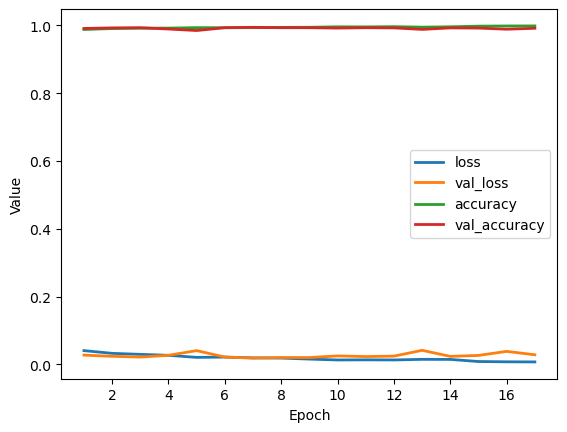

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,TKF,KFC,PRC,QPR,YWT,NNY,CYY,YNN,YYN,RYW,...,PAS,DQQ,ANV,DFK,GNL,TQQ,KKE,ATL,PRE,RRA
0,0.002268,0.002268,0.002268,0.002268,0.002268,0.002268,0.002268,0.002268,0.002268,0.002268,...,0.006803,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001812,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000906,0.0,0.001812
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002012,0.000671,0.000671,0.0,0.0,0.0,0.0,0.000671,0.0,0.000000
3,0.002941,0.002941,0.002941,0.002941,0.005882,0.002941,0.000000,0.000000,0.000000,0.002941,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 1000)
X_test: (2257, 1000)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:20 722ms/step - accuracy: 0.5781 - loss: 0.6931

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6072 - loss: 0.6896    

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7035 - loss: 0.6731

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.6284

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7990 - loss: 0.5726

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.5197

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8405 - loss: 0.4876 - val_accuracy: 0.9939 - val_loss: 0.0241


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0109

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0144 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0161

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0166

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0163

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0160

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0160 - val_accuracy: 0.9956 - val_loss: 0.0184


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0012

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0147 

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0132

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0120

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0120

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0122

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0121

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9983 - val_loss: 0.0067


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0037

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0043 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0042

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0040

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0038

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0036

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9983 - val_loss: 0.0066


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.1639e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0122     

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0093

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0077

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0067

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0060

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9983 - val_loss: 0.0072


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0036

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9449e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 7.1227e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 7.1662e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 7.7006e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.0159e-04 - val_accuracy: 0.9983 - val_loss: 0.0033


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 2.2528e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8111e-04 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9591e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 3.3509e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 4.0140e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 4.2480e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 4.2956e-04 - val_accuracy: 0.9989 - val_loss: 0.0028


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 8.0319e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5446e-04 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7512e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8619e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9360e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0603e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1282e-04 - val_accuracy: 0.9989 - val_loss: 0.0028


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.4888e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0728e-04 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7046e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5088e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3684e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2717e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1834e-04 - val_accuracy: 0.9989 - val_loss: 0.0026


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.8641e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8454e-05 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6835e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6311e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.7924e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8576e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8958e-05 - val_accuracy: 0.9989 - val_loss: 0.0025


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.2983e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2169e-05 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1682e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.8147e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1373e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2138e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2312e-04 - val_accuracy: 0.9983 - val_loss: 0.0026


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.9228e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4119e-05 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9978e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5452e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9016e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2148e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3491e-05 - val_accuracy: 0.9989 - val_loss: 0.0025


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.6922e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9147e-05 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6615e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8485e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0076e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9510e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0652e-05 - val_accuracy: 0.9983 - val_loss: 0.0050


Epoch 14/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.9855e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0014     

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0021

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0022

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0021

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0021

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9989 - val_loss: 0.0024


Epoch 15/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.4078e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1892e-04 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4792e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6426e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6531e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5935e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5367e-04 - val_accuracy: 0.9994 - val_loss: 0.0015


Epoch 16/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.9953e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2063e-04 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0994e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8419e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0771e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5102e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1498e-05 - val_accuracy: 0.9989 - val_loss: 0.0017


Epoch 17/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.5053e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.6826e-05 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.7868e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.0695e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9162e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8918e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8291e-05 - val_accuracy: 0.9994 - val_loss: 0.0012


Epoch 18/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.4713e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0211e-05 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0167e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7899e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7222e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7309e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7332e-05 - val_accuracy: 0.9989 - val_loss: 0.0015


Epoch 19/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.1534e-06

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2689e-05 

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0775e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9571e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8522e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7709e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7141e-05 - val_accuracy: 0.9989 - val_loss: 0.0014


Epoch 20/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 9.6302e-06

 21/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0545e-05 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2396e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3167e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4507e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6371e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7112e-05 - val_accuracy: 0.9994 - val_loss: 0.0012


Epoch 21/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.7645e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5511e-05 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6096e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7429e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6551e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5388e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4515e-05 - val_accuracy: 0.9989 - val_loss: 0.0016


Epoch 22/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.2521e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8042e-06 

 41/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.3463e-06

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9979e-06

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0529e-06

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0020e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0538e-05 - val_accuracy: 0.9994 - val_loss: 0.0012


Epoch 23/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.8350e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.8504e-06 

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1424e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2206e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4934e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4470e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2951e-05 - val_accuracy: 0.9989 - val_loss: 0.0017


Epoch 24/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.0655e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5816e-06 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0780e-06

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8516e-06

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3280e-06

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4724e-06

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5253e-06 - val_accuracy: 0.9983 - val_loss: 0.0013


Epoch 25/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.7526e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0301e-06 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8017e-06

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3174e-06

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3556e-06

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5745e-06

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.9099e-06 - val_accuracy: 0.9989 - val_loss: 0.0016



[Train Accuracy: 100.00% - Test Accuracy: 99.73%]


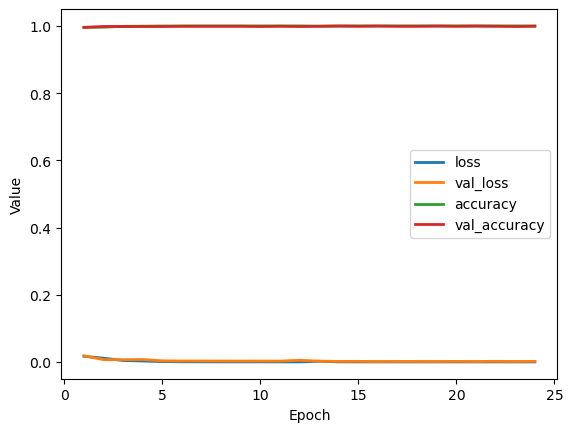

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAEI,AAKS,AALS,AARA,AAYW,ACKR,ACPR,ACQR,ACRR,ADRA,...,YWSQ,YWTA,YWTE,YWTG,YWTH,YWTK,YWTQ,YWTR,YYNN,YYRC
0,0.0,0.0,0.002273,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.002273,0.0,0.00000,0.002273,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00295,0.0,...,0.0,0.0,0.0,0.00295,0.0,0.000000,0.0,0.00295,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:14 665ms/step - accuracy: 0.6250 - loss: 0.6931

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5796 - loss: 0.6906    

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6631 - loss: 0.6806

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.6504

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7638 - loss: 0.6066

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7931 - loss: 0.5596

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8132 - loss: 0.5215 - val_accuracy: 0.9961 - val_loss: 0.0165


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0085

 20/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0162 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0210

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0224

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0229

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0232

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0235 - val_accuracy: 0.9961 - val_loss: 0.0103


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0034

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0149 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0136

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0141

 72/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0153

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0158

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0160

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 0.0145


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0150

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0108 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0106

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0110

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0123

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0138

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0147

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0039


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0050

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0069 

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0091

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0094

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0094

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0095

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0096 - val_accuracy: 0.9994 - val_loss: 0.0017


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0014

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0140 

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0102

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0091

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0088

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0086

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0087

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0016


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0020

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0137 

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0121

 55/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0107

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0102

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0101

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0098

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accuracy: 0.9994 - val_loss: 0.0018


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9844 - loss: 0.0936

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0244 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0179

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0149

 74/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0130

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0122

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0116

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0115 - val_accuracy: 0.9994 - val_loss: 0.0021


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.9079e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0045     

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0056

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0058

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0058

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0058

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0059 - val_accuracy: 0.9989 - val_loss: 0.0028


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - loss: 7.6985e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0090     

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0095

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0097

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0095

 41/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0093

 48/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0095

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0095

 55/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0095

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0095

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9982 - loss: 0.0095

 62/113 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9982 - loss: 0.0095

 69/113 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9982 - loss: 0.0095

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0094 

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0092

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9983 - loss: 0.0090

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9983 - loss: 0.0088

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9983 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 5.8174e-04


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0070

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0026

 55/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0025

 74/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0026

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0026

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0028

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 8.1354e-04


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0023

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5494e-04

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0016    

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0023

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0028

 84/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0033

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0035

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 3.3769e-04


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.3812e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0038     

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0057

 55/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0058

 73/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0057

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0054

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0052

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9989 - val_loss: 0.0027



[Train Accuracy: 99.90% - Test Accuracy: 99.38%]


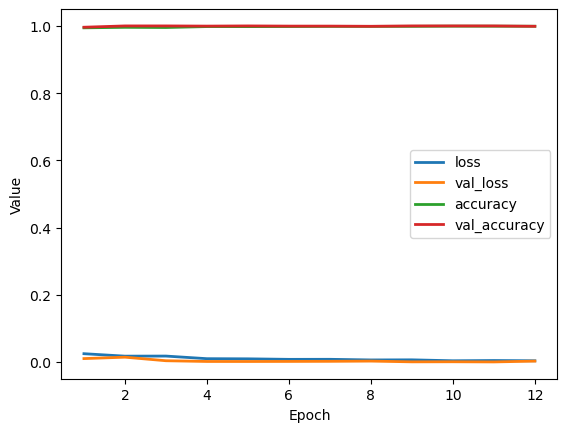

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

47/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAYW,AAEIR,AAKSS,AALKC,AALSR,AAMSR,AARAY,ACKRY,ACPRC,ACQRY,...,YWTAG,YWTEG,YWTGM,YWTHG,YWTKG,YWTQG,YWTRG,YWTSG,YYNNY,YYRCT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.002278,0.0,0.000000,0.0,0.002278,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.002959,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:08 616ms/step - accuracy: 0.4844 - loss: 0.6933

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5774 - loss: 0.6915    

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6554 - loss: 0.6869

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7104 - loss: 0.6767

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.6573

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7810 - loss: 0.6250

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - loss: 0.5871

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8254 - loss: 0.5510

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8378 - loss: 0.5246

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8442 - loss: 0.5103 - val_accuracy: 0.9928 - val_loss: 0.0331


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0443

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9910 - loss: 0.0364 

 25/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9919 - loss: 0.0330

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9921 - loss: 0.0336

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0338

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9924 - loss: 0.0334

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9925 - loss: 0.0333

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9925 - loss: 0.0333

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9926 - loss: 0.0331

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9926 - loss: 0.0330

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9926 - loss: 0.0329 - val_accuracy: 0.9906 - val_loss: 0.0436


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0096

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0142 

 25/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0190

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0209

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0221

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.0228

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.0228

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0227

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0228

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0229

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9957 - loss: 0.0231 - val_accuracy: 0.9928 - val_loss: 0.0347


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0142

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0239 

 25/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0184

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0161

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9945 - loss: 0.0164

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0166

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0172

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0176

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.0178

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9951 - loss: 0.0181

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9951 - loss: 0.0182 - val_accuracy: 0.9945 - val_loss: 0.0219


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0102

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0139 

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.0220

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0244

 48/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0250

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0250

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0245

 83/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0239

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0235

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0231

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9960 - loss: 0.0229 - val_accuracy: 0.9961 - val_loss: 0.0205


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0163

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0165 

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9972 - loss: 0.0191

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9969 - loss: 0.0194

 46/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0197

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0199

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9966 - loss: 0.0201

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0201

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0201

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0200

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9965 - loss: 0.0198 - val_accuracy: 0.9928 - val_loss: 0.0327


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1956

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.0766 

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9887 - loss: 0.0581

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0.0475

 49/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0406

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0368

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9934 - loss: 0.0341

 83/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0319

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0302

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0289

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9945 - loss: 0.0282 - val_accuracy: 0.9950 - val_loss: 0.0208


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0024

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0096 

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0118

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0117

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0122

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0127

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0132

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0139

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0144

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0146

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9973 - loss: 0.0147 - val_accuracy: 0.9950 - val_loss: 0.0193


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0029

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0222 

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9966 - loss: 0.0197

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9966 - loss: 0.0200

 46/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0201

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0199

 68/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0196

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0193

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0192

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0189

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9965 - loss: 0.0187 - val_accuracy: 0.9950 - val_loss: 0.0204


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0016

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0045

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0070

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0090

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0108

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0118

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0124

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0127

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0128

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9975 - loss: 0.0131 - val_accuracy: 0.9939 - val_loss: 0.0299


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.7243e-04

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0135     

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0153

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0143

 50/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0131

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0123

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0129

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0139

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.0146

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0151

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9969 - loss: 0.0153 - val_accuracy: 0.9961 - val_loss: 0.0155


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0173

 11/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0063 

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0068

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0114

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0140

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0149

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0153

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0157

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0161

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0163

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0165

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9973 - loss: 0.0165 - val_accuracy: 0.9945 - val_loss: 0.0260


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0989

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0266 

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0213

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0187

 48/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0170

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0163

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0158

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0157

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0157

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0158

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9974 - loss: 0.0158 - val_accuracy: 0.9956 - val_loss: 0.0204


Epoch 14/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0023

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0025 

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0034

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0053

 46/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0060

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0067

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0072

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0078

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0085

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0092

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0096 - val_accuracy: 0.9961 - val_loss: 0.0168


Epoch 15/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0436

 13/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0225 

 25/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0208

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0196

 49/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0185

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0178

 73/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0171

 85/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0166

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0162

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0159

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9956 - val_loss: 0.0208



[Train Accuracy: 99.75% - Test Accuracy: 99.51%]


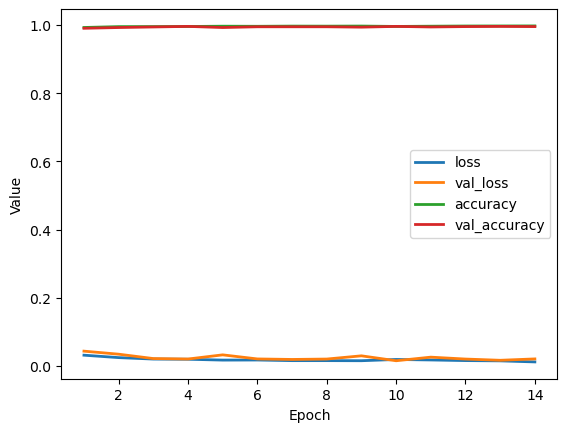

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


Report saved as Output/Reports/Dof/report_full_GHJHWQG6.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################